In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
from utils.make_dataset import *
from utils.transforms import *
from detection.detector_utils import *
from detection.dummy_albu_mapper import *

import cv2
from glob import glob
import os
import re
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import json, random
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog
from detectron2.data import MetadataCatalog
from detectron2.data import transforms as T

import glob
from PIL import Image, ImageDraw


Populating the interactive namespace from numpy and matplotlib


In [2]:
#DatasetImages = PreprocessedDatasetFull()
#data_list_FS = DatasetImages.make_in_memory_dataset('ill', 'cor', ['STIR', 'FS', 'TRIM', 'fs', 'DARK', 'SPAIR', 'stir'],
#                                                    drop_types = ['DIRTY', 'SPINE','PELVIS' ] , crop=False, best_slice=False, resize=False )

#data_list = data_list_FS

In [3]:
DatasetImages = PreprocessedDatasetPart1()
data_list_FS = DatasetImages.make_in_memory_dataset('ill', 'cor', ['PD_FS', 'T1_FS', 'T2_FS', 'STIR', 'TRIM', 'T1_DARK', 'SPAIR', 'T2_DARK', 'PD_DARK' ]
                                                    , drop_types = ['DIRTY', 'SPINE','PELVIS' ] , crop=False, best_slice=False, resize=False ,stack_images=False)
DATASET_NAME = 'joints_large_FS'
DATASET_PATH = 'detection/data/cor_large_FS'
MODEL_NAME = 'Detector_LARGE_FS.pth'

#data_list_Full = DatasetImages.make_in_memory_dataset('ill', 'cor', ['PD', 'T1', 'T2', 'STIR',], drop_types = ['DIRTY'] , crop=False, best_slice=False, resize=False ,stack_images=False)
#data_list_FS = DatasetImages.make_in_memory_dataset(task, projection, researh_types, drop_types, crop=True, best_slice=True, resize=False )    

#data_list_Light = DatasetImages.make_in_memory_dataset('ill', 'cor', ['PD', 'T1', 'T2'], drop_types = ['DIRTY', 'STIR', 'FS', 'TRIM', 'fs', 'DARK', 'SPAIR', 'SPINE', 'NF'] , crop=False, best_slice=False, resize=False ,stack_images=False)
#DATASET_NAME = 'joints_large_Full'
#DATASET_PATH = 'detection/data/cor_large_L'
#MODEL_NAME = 'Detector_LARGE_UNI.pth'

data_list = data_list_FS

133  dataset length


T2_DARK
data/27.npy
20


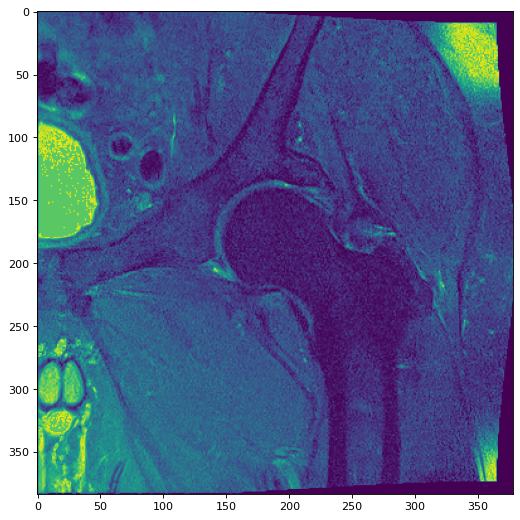

In [57]:
i = 7
images = data_list[i]['images']
path = data_list[i]['path']
best_slice = data_list[i]['best_slice'] 
box = np.array(data_list[i]['box'])
image = images[best_slice].copy()
image = image
print(data_list[i]['researh_type'])
print(data_list[i]['path'])
print(len(images))
color = (255, 0, 0)  
thickness = 2  
#image = cv2.rectangle(image,  (int(box[0]), int(box[1])) , (int(box[2]),int(box[3])),  color, thickness)
figure(figsize=(8, 8), dpi=80)
imgplot = plt.imshow(image)
plt.show()


In [58]:
def dataset_format_train():    
    dataset = dataset_train       
    return dataset    

def dataset_format_val():    
    dataset = dataset_val       
    return dataset    
  

In [59]:
dataset_train, dataset_val = make_jpeg_dataset(data_list, base_path = DATASET_PATH, images_already_exist = False)

In [9]:
#with open('detection/dataset_train.json', 'w') as fp:
#    json.dump(dataset_train, fp)
#with open('detection/dataset_val.json', 'w') as fp:
#    json.dump(dataset_train, fp)

#with open('detection/dataset_train.json') as json_file:
#    dataset_train = json.load(json_file) 
#with open('detection/dataset_val.json') as json_file:
#    dataset_val = json.load(json_file)

In [10]:
#!rm detection/data/cor/*.jpg

In [11]:
DatasetCatalog.register(DATASET_NAME + "_train", dataset_format_train)
DatasetCatalog.register(DATASET_NAME + "_val", dataset_format_val) 

MetadataCatalog.get(DATASET_NAME + "_train").thing_classes = ["joint"]
MetadataCatalog.get(DATASET_NAME + "_val").thing_classes = ["joint"]

joints_metadata = MetadataCatalog.get(DATASET_NAME + "_train")

In [12]:
#DatasetCatalog.remove(DATASET_NAME + "_train")
#DatasetCatalog.remove(DATASET_NAME + "_val")

In [60]:
from detectron2.engine import DefaultTrainer
from detectron2.data import DatasetMapper, MetadataCatalog, build_detection_train_loader, build_detection_test_loader


class Trainer(DefaultTrainer):
    
    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(cfg, dataset_name, mapper=DatasetMapper(cfg, False))

    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=DatasetMapper(cfg, is_train=True, augmentations= [
                                                                      T.RandomBrightness(0.8, 1.2),
                                                                      #T.HFlipTransform(), 
                                                                                                          ], ))

In [61]:
#detection/model_final_971ab9.pkl
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("Base-RetinaNet.yaml"))
cfg.DATASETS.TRAIN = (DATASET_NAME + "_train",)
cfg.DATASETS.TEST = (DATASET_NAME + "_val",)
#cfg.TEST.EVAL_PERIOD = 50
cfg.DATALOADER.NUM_WORKERS = 10
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00015  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg) 
trainer.resume_or_load(resume=False)

Loading config /home/teshbek/anaconda3/envs/mrnet/lib/python3.9/site-packages/detectron2/model_zoo/configs/Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[07/19 02:08:39 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

KeyError: "Dataset 'joints_large_FS_train' is not registered! Available datasets are: coco_2014_train, coco_2014_val, coco_2014_minival, coco_2014_minival_100, coco_2014_valminusminival, coco_2017_train, coco_2017_val, coco_2017_test, coco_2017_test-dev, coco_2017_val_100, keypoints_coco_2014_train, keypoints_coco_2014_val, keypoints_coco_2014_minival, keypoints_coco_2014_valminusminival, keypoints_coco_2014_minival_100, keypoints_coco_2017_train, keypoints_coco_2017_val, keypoints_coco_2017_val_100, coco_2017_train_panoptic_separated, coco_2017_train_panoptic_stuffonly, coco_2017_train_panoptic, coco_2017_val_panoptic_separated, coco_2017_val_panoptic_stuffonly, coco_2017_val_panoptic, coco_2017_val_100_panoptic_separated, coco_2017_val_100_panoptic_stuffonly, coco_2017_val_100_panoptic, lvis_v1_train, lvis_v1_val, lvis_v1_test_dev, lvis_v1_test_challenge, lvis_v0.5_train, lvis_v0.5_val, lvis_v0.5_val_rand_100, lvis_v0.5_test, lvis_v0.5_train_cocofied, lvis_v0.5_val_cocofied, cityscapes_fine_instance_seg_train, cityscapes_fine_sem_seg_train, cityscapes_fine_instance_seg_val, cityscapes_fine_sem_seg_val, cityscapes_fine_instance_seg_test, cityscapes_fine_sem_seg_test, cityscapes_fine_panoptic_train, cityscapes_fine_panoptic_val, voc_2007_trainval, voc_2007_train, voc_2007_val, voc_2007_test, voc_2012_trainval, voc_2012_train, voc_2012_val, ade20k_sem_seg_train, ade20k_sem_seg_val"

In [15]:
trainer.train()

[07/17 13:43:23 d2.engine.train_loop]: Starting training from iteration 0


/home/teshbek/anaconda3/envs/mrnet/lib/python3.9/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/home/teshbek/anaconda3/envs/mrnet/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[07/17 13:43:32 d2.utils.events]:  eta: 0:06:55  iter: 19  total_loss: 1.124  loss_cls: 0.6862  loss_box_reg: 0.4831  time: 0.4237  data_time: 0.0116  lr: 2.9971e-06  max_mem: 2593M
[07/17 13:43:36 d2.utils.events]:  eta: 0:05:51  iter: 39  total_loss: 1.405  loss_cls: 0.8223  loss_box_reg: 0.5698  time: 0.3122  data_time: 0.0016  lr: 5.9941e-06  max_mem: 2593M
[07/17 13:43:39 d2.utils.events]:  eta: 0:02:54  iter: 59  total_loss: 1.259  loss_cls: 0.6679  loss_box_reg: 0.5844  time: 0.2614  data_time: 0.0018  lr: 8.9911e-06  max_mem: 2593M
[07/17 13:43:42 d2.utils.events]:  eta: 0:02:21  iter: 79  total_loss: 1.055  loss_cls: 0.5258  loss_box_reg: 0.5326  time: 0.2338  data_time: 0.0016  lr: 1.1988e-05  max_mem: 2593M
[07/17 13:43:45 d2.utils.events]:  eta: 0:02:15  iter: 99  total_loss: 1.006  loss_cls: 0.4813  loss_box_reg: 0.491  time: 0.2148  data_time: 0.0016  lr: 1.4985e-05  max_mem: 2593M
[07/17 13:43:49 d2.utils.events]:  eta: 0:02:12  iter: 119  total_loss: 0.8223  loss_cls: 0

In [16]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator(DATASET_NAME + "_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, DATASET_NAME + "_val", mapper=None)
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [07/17 13:46:10 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[07/17 13:46:10 d2.evaluation.coco_evaluation]: 'joints_large_FS_val' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
WARNING [07/17 13:46:10 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/joints_large_FS_val_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[07/17 13:46:10 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/17 13:46:10 d2.data.common]: Serializing 28 elements to byte tensors and concatenating them all ...
[07/17 13:46:10 d2.data.common]: Serialized dataset takes 0.01 MiB
[07/17 13:46:10 d2.evaluation.evaluator]: Start inference on 28 batches
[07/17 13:46:11 d2.evalu

OrderedDict([('bbox',
              {'AP': 15.357481269717024,
               'AP50': 38.41669184575544,
               'AP75': 2.6063508606499743,
               'APs': nan,
               'APm': 32.85478547854785,
               'APl': 15.3041719688837})])

In [62]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

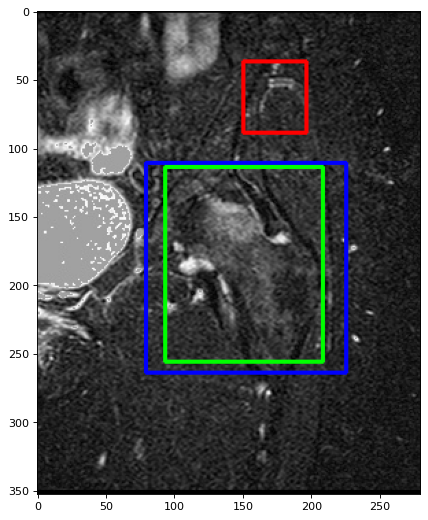

[150.47961   37.718143 196.92964   89.40081 ]


In [67]:
color = (255, 0, 0)  
t_color = (0, 255, 0)  
s_color = (0, 0, 255)  

thickness = 2  
dataset_dicts = dataset_val

for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  
    pred_boxes = outputs["instances"].to("cpu").pred_boxes[0].tensor.numpy()[0]
    pred_boxes2 = outputs["instances"].to("cpu").pred_boxes[1].tensor.numpy()[0]

    true_boxes = d['annotations'][0]['bbox']
    image = cv2.rectangle(im,  (int(true_boxes[0]), int(true_boxes[1])) , (int(true_boxes[2]),int(true_boxes[3])),  t_color, thickness)
    
    image = cv2.rectangle(image,  (int(pred_boxes[0]), int(pred_boxes[1])) , (int(pred_boxes[2]),int(pred_boxes[3])),  color, thickness)
    image = cv2.rectangle(image,  (int(pred_boxes2[0]), int(pred_boxes2[1])) , (int(pred_boxes2[2]),int(pred_boxes2[3])),  s_color, thickness)
   
    figure(figsize=(8, 8), dpi=80)
    imgplot = plt.imshow(image)
    plt.show()

    print(pred_boxes)

In [69]:
def if_small(box, image):
    
    startX, startY, endX, endY = box
    
    s_box = (endX - startX )* (endY - startY) 
    s_image = image.shape[0] * image.shape[1]
    if s_box/s_image > 0.05:    
        return True
    else: 
        return False
    

True


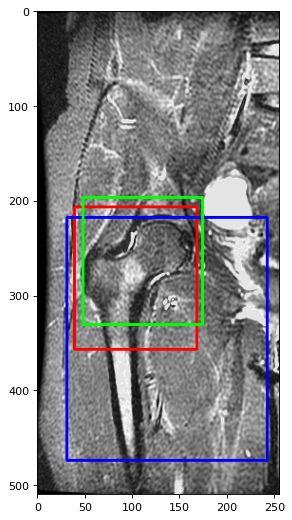

[ 39.08025 207.03683 168.17886 357.08588]
[ 31.75766 218.20932 242.30533 474.2938 ]


In [85]:
color = (255, 0, 0)  
t_color = (0, 255, 0)  
s_color = (0, 0, 255)  

thickness = 2  
dataset_dicts = dataset_val

for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  
    pred_boxes = outputs["instances"].to("cpu").pred_boxes[0].tensor.numpy()[0]
    pred_boxes2 = outputs["instances"].to("cpu").pred_boxes[1].tensor.numpy()[0]

    true_boxes = d['annotations'][0]['bbox']
    
    print(if_small(pred_boxes, im))
    image = cv2.rectangle(im,  (int(pred_boxes[0]), int(pred_boxes[1])) , (int(pred_boxes[2]),int(pred_boxes[3])),  color, thickness)
   
    image = cv2.rectangle(im,  (int(pred_boxes2[0]), int(pred_boxes2[1])) , (int(pred_boxes2[2]),int(pred_boxes2[3])),  s_color, thickness)

    image = cv2.rectangle(image,  (int(true_boxes[0]), int(true_boxes[1])) , (int(true_boxes[2]),int(true_boxes[3])),  t_color, thickness)
    figure(figsize=(8, 8), dpi=80)
    imgplot = plt.imshow(image)
    plt.show()

    print(pred_boxes)
    print(pred_boxes2)

# Small Crop

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
from utils.make_dataset import *
from utils.transforms import *
from detection.detector_utils import *
from detection.dummy_albu_mapper import *

import cv2
from glob import glob
import os
import re
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import json, random
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog
from detectron2.data import MetadataCatalog
from detectron2.data import transforms as T

import glob
from PIL import Image, ImageDraw

Populating the interactive namespace from numpy and matplotlib


In [84]:
annotation_path = 'detection/Smal_Crop/annotations.json'

with open(annotation_path) as json_file:
    annotation_data = json.load(json_file)
print('masks: ',len(list(annotation_data.keys())))
filenames_list = glob.glob('detection/Smal_Crop/images/*.png')
print('images: ', len(filenames_list))

masks:  361
images:  363


In [93]:
def get_box(box):        
    startX = box['x1']
    startY = box['y1'] 
    endX = box['x2']
    endY  = box['y2']
    box = [startX, startY, endX, endY]
    
    return box       

def get_npy_file(element, path = './data'):      
    name = element['path'].split('/')[-1].split('.')[0]
    npy_file_path = os.path.join(path,name + '.npy')
    images = np.load(npy_file_path, allow_pickle=True)
    
    return images, npy_file_path  


In [94]:
crops_dataset_raw = {}

for file in filenames_list:
    png_name = file.split('/')[-1]
    
    if png_name in list(annotation_data.keys()):
        element = {}
        orig_image = Image.open(file)
        width, height = orig_image.size
        img = Image.new('L', (width, height), 0)
        instances = annotation_data[png_name]['instances']
        for instance in instances:
            box = get_box(instance['points'])            
        element['box'] = box
        
        element['path'] = file
        #element['image'] = orig_image
        _ , npy_path = get_npy_file(element)        
        crops_dataset_raw[npy_path] = element  
        

In [95]:
with open('small_boxes.json', 'w') as fp:
    json.dump(crops_dataset_raw, fp)

In [5]:
def predict_box(image, projection, research_type): 
    
    if research_type == 'Light' and projection=='cor':
        cfg = get_cfg()
        cfg.merge_from_file(model_zoo.get_config_file("Base-RetinaNet.yaml"))
        cfg.DATALOADER.NUM_WORKERS = 11
        cfg.SOLVER.IMS_PER_BATCH = 2
        cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
        cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final_large_Light.pth")  
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  
        predictor = DefaultPredictor(cfg)    
    
        #if image.shape[-1]!=256:
        #    image =  cv2.resize(image, (256,256))            
        image = np.stack((image, image, image), axis=-1)
        #image = np.moveaxis(image,0, -1)
        #print(image.shape)
        predictor = DefaultPredictor(cfg)
        outputs = predictor(image)  
        pred_boxes = outputs["instances"].to("cpu").pred_boxes[0].tensor.numpy()[0]    
    else:
        pred_boxes = None
        
    return pred_boxes

In [6]:
DatasetImages = PreprocessedDatasetPart1()

data_list_Light = DatasetImages.make_in_memory_dataset('ill', 'cor', ['PD', 'T1', 'T2'], drop_types = ['DIRTY', 'STIR', 'FS', 'TRIM', 'fs', 'DARK', 'SPAIR', 'SPINE', 'NF'] , crop=False, best_slice=False, resize=False ,stack_images=False)
DATASET_NAME = 'joints_small'
DATASET_PATH = 'detection/data/cor_small_L'

data_list = data_list_Light

bbox resized
215  dataset length


In [7]:
new_keys = list(crops_dataset_raw.keys())

for element in data_list:
    
    if './'+element['path'] in new_keys:
        new_box = crops_dataset_raw['./'+element['path']]['box']     
        new_box = resize_new_box(element['rescaled_box'], new_box)
        element['small_box'] = new_box
        #element['bb_box_large'] = box
                    

(228, 224)


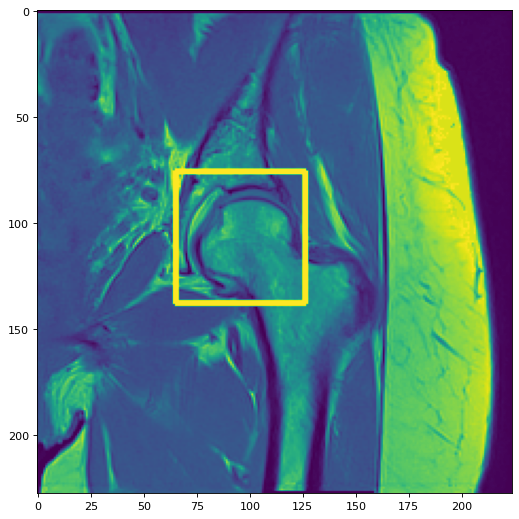

In [8]:
i = 13
images = data_list[i]['images']
path = data_list[i]['path']
best_slice = data_list[i]['best_slice']   
small_box = np.array(data_list[i]['small_box'])
large_box = np.array(data_list[i]['box'])

#box_large = np.array(data_dict[key]['bb_box_large'])

image = images[best_slice].copy()
print(image.shape)

color = (255, 0, 0)  
thickness = 2  
image = cv2.rectangle(image,  (int(small_box[0]), int(small_box[1])) , (int(small_box[2]),int(small_box[3])),  color, thickness)
#image = cv2.rectangle(image,  (int(large_box[0]), int(large_box[1])) , (int(large_box[2]),int(large_box[3])),  color, thickness)

figure(figsize=(8, 8), dpi=80)
imgplot = plt.imshow(image)
plt.show()

In [9]:
def dataset_format_train():    
    dataset = dataset_train       
    return dataset    
def dataset_format_val():    
    dataset = dataset_val       
    return dataset    

In [10]:
dataset_train, dataset_val = make_jpeg_dataset(data_list, base_path = DATASET_PATH, images_already_exist = False, small_box=True)

In [11]:
DatasetCatalog.register(DATASET_NAME + "_train", dataset_format_train)
DatasetCatalog.register(DATASET_NAME + "_val", dataset_format_val) 

MetadataCatalog.get(DATASET_NAME + "_train").thing_classes = ["joint"]
MetadataCatalog.get(DATASET_NAME + "_val").thing_classes = ["joint"]

joints_metadata = MetadataCatalog.get(DATASET_NAME + "_train")

In [12]:
#DatasetCatalog.remove("joints_train")


In [13]:
from detectron2.engine import DefaultTrainer
from detectron2.data import DatasetMapper, MetadataCatalog, build_detection_train_loader, build_detection_test_loader


class Trainer(DefaultTrainer):
    
    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(cfg, dataset_name, mapper=DatasetMapper(cfg, False))

    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=DatasetMapper(cfg, is_train=True, augmentations= [
                                                                      T.RandomBrightness(0.8, 1.2),
                                                                      #T.HFlipTransform(), 
                                                                                                          ], ))

In [14]:
#detection/model_final_971ab9.pkl
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("Base-RetinaNet.yaml"))
cfg.DATASETS.TRAIN = (DATASET_NAME + "_train",)
cfg.DATASETS.TEST = (DATASET_NAME + "_val",)
#cfg.TEST.EVAL_PERIOD = 50
cfg.DATALOADER.NUM_WORKERS = 10
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00015  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg) 
trainer.resume_or_load(resume=False)

Loading config /home/teshbek/anaconda3/envs/mrnet/lib/python3.9/site-packages/detectron2/model_zoo/configs/Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[07/20 13:07:15 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [15]:
trainer.train()

[07/20 13:07:15 d2.engine.train_loop]: Starting training from iteration 0


/home/teshbek/anaconda3/envs/mrnet/lib/python3.9/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/home/teshbek/anaconda3/envs/mrnet/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[07/20 13:07:23 d2.utils.events]:  eta: 0:05:56  iter: 19  total_loss: 1.468  loss_cls: 0.8933  loss_box_reg: 0.5613  time: 0.3807  data_time: 0.0129  lr: 2.9971e-06  max_mem: 1016M
[07/20 13:07:25 d2.utils.events]:  eta: 0:05:31  iter: 39  total_loss: 1.557  loss_cls: 0.927  loss_box_reg: 0.6449  time: 0.2294  data_time: 0.0015  lr: 5.9941e-06  max_mem: 1016M
[07/20 13:07:26 d2.utils.events]:  eta: 0:01:03  iter: 59  total_loss: 1.359  loss_cls: 0.7693  loss_box_reg: 0.6064  time: 0.1716  data_time: 0.0015  lr: 8.9911e-06  max_mem: 1016M
[07/20 13:07:27 d2.utils.events]:  eta: 0:00:57  iter: 79  total_loss: 1.136  loss_cls: 0.614  loss_box_reg: 0.5466  time: 0.1434  data_time: 0.0016  lr: 1.1988e-05  max_mem: 1016M
[07/20 13:07:28 d2.utils.events]:  eta: 0:00:55  iter: 99  total_loss: 1.03  loss_cls: 0.4836  loss_box_reg: 0.5203  time: 0.1281  data_time: 0.0015  lr: 1.4985e-05  max_mem: 1016M
[07/20 13:07:30 d2.utils.events]:  eta: 0:00:56  iter: 119  total_loss: 0.9117  loss_cls: 0.4

In [16]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

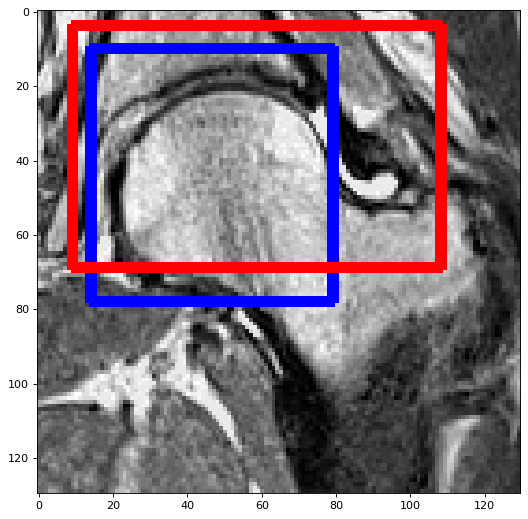

[  9   4 108  69]


In [74]:
from detectron2.utils.visualizer import ColorMode
color = (255, 0, 0)  
color2 = (0, 255, 0)  
t_color = (0, 0, 255) 

thickness = 2  
dataset_dicts = dataset_train

for d in random.sample(dataset_dicts, 1):    
    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    pred_boxes = np.uint8(outputs["instances"].to("cpu").pred_boxes[0].tensor.numpy()[0])
    pred_boxes2 = np.uint8(outputs["instances"].to("cpu").pred_boxes[1].tensor.numpy()[0])
    true_boxes = d['annotations'][0]['bbox']
    image = cv2.rectangle(im,  (int(true_boxes[0]), int(true_boxes[1])) , (int(true_boxes[2]),int(true_boxes[3])),  t_color, thickness)
    
    image = cv2.rectangle(image,  (pred_boxes[0], pred_boxes[1]) , (pred_boxes[2],pred_boxes[3]),  color, thickness)
    #image = cv2.rectangle(im,  (pred_boxes2[0], pred_boxes2[1]) , (pred_boxes2[2],pred_boxes2[3]),  color2, thickness)

    figure(figsize=(8, 8), dpi=80)
    imgplot = plt.imshow(image)
    plt.show()

    print(pred_boxes)